# Sign Language CSV Dataset — PyTorch Training & Evaluation (LSTM)

This notebook loads per-sequence CSV files (pose + hands), pads/truncates sequences to a fixed length, trains a BiLSTM classifier, and produces research-grade evaluation outputs (Top-k accuracy, macro metrics, confusion matrix).


## **x.1 Setup and Reproducibility**


#### x.1.1 Import Libraries

In [1]:
import random
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#### x.1.2 Device and Seed

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Determinism (recommended for research reproducibility)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


Device: cpu


## **x.2 Dataset Configuration and Utilities**


#### x.2.1 Dataset Config

In [3]:
# === CONFIG ===
csv_folder = Path("input/")  # change if needed
pad_len = 83
n_features = 118

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1


#### x.2.2 Filename Parsing

In [4]:
def parse_label_from_filename(csv_path: Path) -> str:
    stem = csv_path.stem
    parts = stem.split("_")
    if len(parts) < 2:
        return stem
    return "_".join(parts[:-1])


#### x.2.3 Padding/truncation

In [5]:
def pad_or_truncate_with_length(sequence_2d: np.ndarray, target_len: int, n_features: int):
    T, F = sequence_2d.shape
    if F != n_features:
        raise ValueError(f"Expected {n_features} features, but got {F}")

    length = min(T, target_len)

    X = np.zeros((target_len, F), dtype=np.float32)
    X[:length, :] = sequence_2d[:length, :].astype(np.float32)

    return X, length


## **x.3 Dataset Indexing and DataLoaders**

#### x.3.1 Build file index

In [6]:
def build_file_index(csv_folder: Path):
    file_paths = sorted(csv_folder.glob("*.csv"))
    if len(file_paths) == 0:
        raise FileNotFoundError(f"No CSV files found in: {csv_folder}")

    labels = [parse_label_from_filename(p) for p in file_paths]

    unique_labels = sorted(set(labels))
    label_to_id = {lab: i for i, lab in enumerate(unique_labels)}
    id_to_label = {i: lab for lab, i in label_to_id.items()}

    return file_paths, labels, label_to_id, id_to_label


In [7]:
file_paths, labels, label_to_id, id_to_label = build_file_index(csv_folder)

print("Total sequences:", len(file_paths))
print("Total classes  :", len(label_to_id))
print("Example labels :", list(label_to_id.keys())[:10])


Total sequences: 21711
Total classes  : 1331
Example labels : ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18']


#### x.3.2 Train/Val/Test split


In [8]:
def stratified_split(file_paths, labels, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=42):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-9

    rng = np.random.default_rng(seed)

    label_to_indices = defaultdict(list)
    for i, lab in enumerate(labels):
        label_to_indices[lab].append(i)

    train_idx, val_idx, test_idx = [], [], []

    for lab, idxs in label_to_indices.items():
        idxs = np.array(idxs)
        rng.shuffle(idxs)

        n = len(idxs)
        n_train = int(round(n * train_ratio))
        n_val = int(round(n * val_ratio))
        n_test = n - n_train - n_val

        train_idx.extend(idxs[:n_train].tolist())
        val_idx.extend(idxs[n_train:n_train + n_val].tolist())
        test_idx.extend(idxs[n_train + n_val:].tolist())

    rng.shuffle(train_idx)
    rng.shuffle(val_idx)
    rng.shuffle(test_idx)

    return {"train": train_idx, "val": val_idx, "test": test_idx}


In [9]:
splits = stratified_split(
    file_paths, labels,
    train_ratio=train_ratio,
    val_ratio=val_ratio,
    test_ratio=test_ratio,
    seed=42
)

print("Train:", len(splits["train"]))
print("Val  :", len(splits["val"]))
print("Test :", len(splits["test"]))


Train: 17849
Val  : 1932
Test : 1930


#### x.3.3 PyTorch Dataset

In [10]:
class SignCSVDataset(Dataset):
    def __init__(self, file_paths, labels, label_to_id, pad_len, n_features=118):
        self.file_paths = file_paths
        self.labels = labels
        self.label_to_id = label_to_id
        self.pad_len = pad_len
        self.n_features = n_features

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        csv_path = self.file_paths[idx]
        label_str = self.labels[idx]
        y = self.label_to_id[label_str]

        df = pd.read_csv(csv_path)
        seq = df.values

        X_np, length = pad_or_truncate_with_length(seq, self.pad_len, self.n_features)

        X = torch.from_numpy(X_np)
        y = torch.tensor(y, dtype=torch.long)
        length = torch.tensor(length, dtype=torch.long)

        return X, y, length, csv_path.name


#### x.3.4 Collate Function

In [11]:
def collate_fn(batch):
    X_list, y_list, length_list, fname_list = zip(*batch)

    X_batch = torch.stack(X_list, dim=0)
    y_batch = torch.stack(y_list, dim=0)
    lengths = torch.stack(length_list, dim=0)

    return X_batch, y_batch, lengths, list(fname_list)

In [12]:
train_paths = [file_paths[i] for i in splits["train"]]
train_labels = [labels[i] for i in splits["train"]]

val_paths = [file_paths[i] for i in splits["val"]]
val_labels = [labels[i] for i in splits["val"]]

test_paths = [file_paths[i] for i in splits["test"]]
test_labels = [labels[i] for i in splits["test"]]

train_dataset = SignCSVDataset(train_paths, train_labels, label_to_id, pad_len, n_features)
val_dataset   = SignCSVDataset(val_paths,   val_labels,   label_to_id, pad_len, n_features)
test_dataset  = SignCSVDataset(test_paths,  test_labels,  label_to_id, pad_len, n_features)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=0, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)

print("Train batches:", len(train_loader))
print("Val batches  :", len(val_loader))
print("Test batches :", len(test_loader))


Train batches: 279
Val batches  : 31
Test batches : 31


In [13]:
Xb, yb, lengths, fnames = next(iter(train_loader))

print("Xb shape:", Xb.shape)
print("yb shape:", yb.shape)
print("lengths min/max:", int(lengths.min()), int(lengths.max()))
print("Example:", fnames[0], "-> class", int(yb[0]), "label", id_to_label[int(yb[0])])


Xb shape: torch.Size([64, 83, 118])
yb shape: torch.Size([64])
lengths min/max: 11 83
Example: w_097.csv -> class 1325 label w


## 5) Model — BiLSTM with Masked Mean Pooling


In [14]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.2):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, X, lengths):
        out, _ = self.lstm(X)

        B, T, D = out.shape

        mask = torch.arange(T, device=out.device).unsqueeze(0) < lengths.unsqueeze(1)
        mask_f = mask.float().unsqueeze(-1)

        summed = (out * mask_f).sum(dim=1)
        denom = lengths.clamp(min=1).unsqueeze(1).float()

        feat = summed / denom
        logits = self.classifier(feat)
        return logits


## 6) Training Utilities


In [15]:
def accuracy_from_logits(logits, y_true):
    preds = torch.argmax(logits, dim=1)
    return (preds == y_true).float().mean().item()


In [16]:
def run_one_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    loss_fn = nn.CrossEntropyLoss()

    total_loss = 0.0
    total_acc = 0.0
    n_batches = 0

    for Xb, yb, lengths, fnames in loader:
        Xb = Xb.to(device)
        yb = yb.to(device)
        lengths = lengths.to(device)

        if is_train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(is_train):
            logits = model(Xb, lengths)
            loss = loss_fn(logits, yb)
            acc = accuracy_from_logits(logits, yb)

            if is_train:
                loss.backward()
                optimizer.step()

        total_loss += loss.item()
        total_acc += acc
        n_batches += 1

    return total_loss / n_batches, total_acc / n_batches


## 7) Train


In [17]:
num_classes = len(label_to_id)

model = BiLSTMClassifier(
    input_size=n_features,
    hidden_size=128,
    num_layers=2,
    num_classes=num_classes,
    dropout=0.2
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print("Model params:", sum(p.numel() for p in model.parameters()))


Model params: 853811


In [18]:
epochs = 5

for epoch in range(1, epochs + 1):
    train_loss, train_acc = run_one_epoch(model, train_loader, optimizer=optimizer)
    val_loss, val_acc = run_one_epoch(model, val_loader, optimizer=None)

    print(f"Epoch {epoch:02d} | "
          f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
          f"val loss {val_loss:.4f} acc {val_acc:.4f}")


Epoch 01 | train loss 5.1125 acc 0.0245 | val loss 4.0671 acc 0.0596
Epoch 02 | train loss 4.2154 acc 0.0694 | val loss 3.3522 acc 0.1221
Epoch 03 | train loss 3.3917 acc 0.1473 | val loss 2.3522 acc 0.2641
Epoch 04 | train loss 2.6662 acc 0.2517 | val loss 1.7716 acc 0.3873
Epoch 05 | train loss 2.3242 acc 0.3308 | val loss 1.5134 acc 0.4612


In [26]:
from pathlib import Path
import torch

def save_checkpoint(path, model, label_to_id, id_to_label, pad_len, n_features,
                    hidden_size=128, num_layers=2, dropout=0.2):
    """
    Saves everything needed for external validation / inference:
    - model weights
    - label mapping
    - padding length & feature dim
    - model hyperparams (so you can reconstruct the model later)
    """
    ckpt = {
        "state_dict": model.state_dict(),
        "label_to_id": label_to_id,
        "id_to_label": id_to_label,
        "pad_len": int(pad_len),
        "n_features": int(n_features),
        "hidden_size": int(hidden_size),
        "num_layers": int(num_layers),
        "dropout": float(dropout),
    }
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    torch.save(ckpt, path)
    print(f"[SAVED] checkpoint -> {path.resolve()}")

# Example usage (match your model settings):
save_checkpoint(
    "checkpoints/best_lstm.pt",
    model=model,
    label_to_id=label_to_id,
    id_to_label=id_to_label,
    pad_len=pad_len,          # 83
    n_features=n_features,    # 118
    hidden_size=128,
    num_layers=2,
    dropout=0.2
)


[SAVED] checkpoint -> D:\Projects\Python\SIBIFullBody312\3_training\checkpoints\best_lstm.pt


## 8) Research-Grade Evaluation (Top-k, Macro/Micro, Confusion Matrix)


In [20]:
@torch.no_grad()
def evaluate_collect_predictions(model, loader, device, k_list=(1, 3, 5)):
    model.eval()

    all_true = []
    all_pred = []
    all_prob = []

    correct_topk = {k: 0 for k in k_list}
    total = 0

    for Xb, yb, lengths, fnames in loader:
        Xb = Xb.to(device)
        yb = yb.to(device)
        lengths = lengths.to(device)

        logits = model(Xb, lengths)
        prob = torch.softmax(logits, dim=1)
        pred = torch.argmax(prob, dim=1)

        for k in k_list:
            topk = torch.topk(prob, k=k, dim=1).indices
            correct_topk[k] += (topk == yb.unsqueeze(1)).any(dim=1).sum().item()

        all_true.append(yb.cpu())
        all_pred.append(pred.cpu())
        all_prob.append(prob.cpu())

        total += yb.size(0)

    y_true = torch.cat(all_true).numpy()
    y_pred = torch.cat(all_pred).numpy()
    y_prob = torch.cat(all_prob).numpy()

    topk_acc = {f"top{k}": correct_topk[k] / total for k in k_list}
    return y_true, y_pred, y_prob, topk_acc


In [21]:
def compute_confusion_matrix(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm


In [22]:
def safe_classification_report(y_true, y_pred, target_names=None):
    try:
        from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score

        report = classification_report(
            y_true, y_pred,
            target_names=target_names,
            digits=4,
            zero_division=0
        )

        metrics = {
            "accuracy": float(accuracy_score(y_true, y_pred)),
            "macro_f1": float(f1_score(y_true, y_pred, average="macro", zero_division=0)),
            "micro_f1": float(f1_score(y_true, y_pred, average="micro", zero_division=0)),
            "macro_precision": float(precision_score(y_true, y_pred, average="macro", zero_division=0)),
            "macro_recall": float(recall_score(y_true, y_pred, average="macro", zero_division=0)),
        }
        return report, metrics

    except Exception as e:
        report = f"[sklearn not available] {e}"
        metrics = {"accuracy": float((y_true == y_pred).mean())}
        return report, metrics


In [23]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, class_names, normalize=False, title="Confusion Matrix"):
    cm_plot = cm.astype(np.float64)

    if normalize:
        row_sums = cm_plot.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1.0
        cm_plot = cm_plot / row_sums

    plt.figure(figsize=(10, 8))
    plt.imshow(cm_plot)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")

    n = len(class_names)
    step = max(1, n // 30)
    tick_positions = np.arange(0, n, step)

    plt.xticks(tick_positions, [class_names[i] for i in tick_positions], rotation=90)
    plt.yticks(tick_positions, [class_names[i] for i in tick_positions])

    plt.colorbar()
    plt.tight_layout()
    plt.show()


## 9) Run Evaluation & Save Outputs


=== TOP-K ACCURACY ===
top1: 0.4585
top3: 0.8187
top5: 0.9301

=== SUMMARY METRICS ===
accuracy: 0.4585

=== CLASSIFICATION REPORT ===
[sklearn not available] Number of classes, 184, does not match size of target_names, 1331. Try specifying the labels parameter


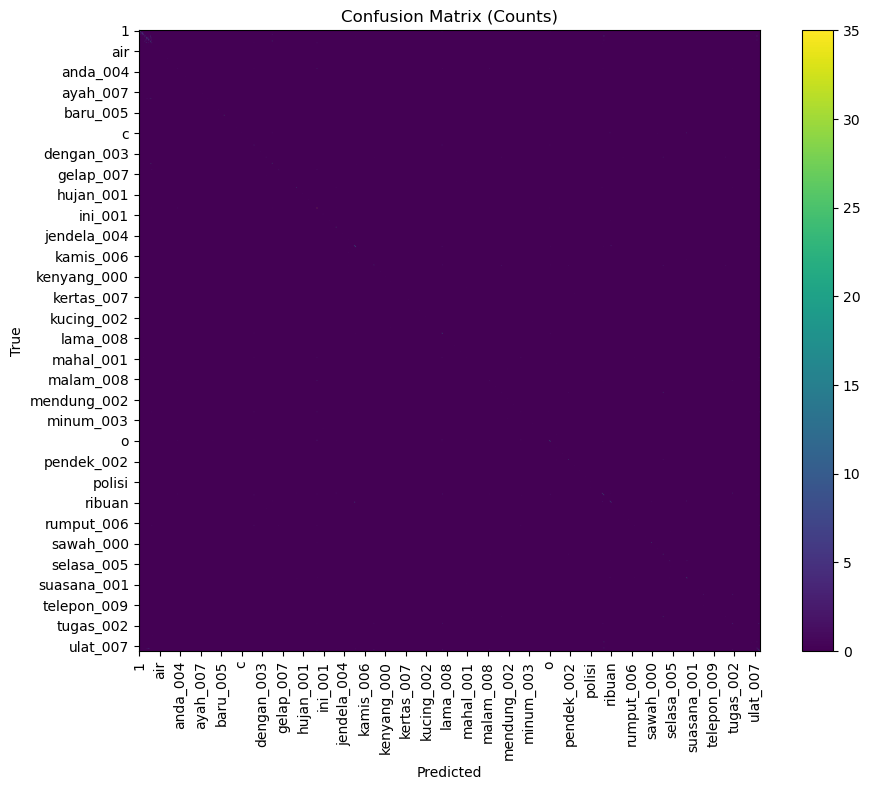

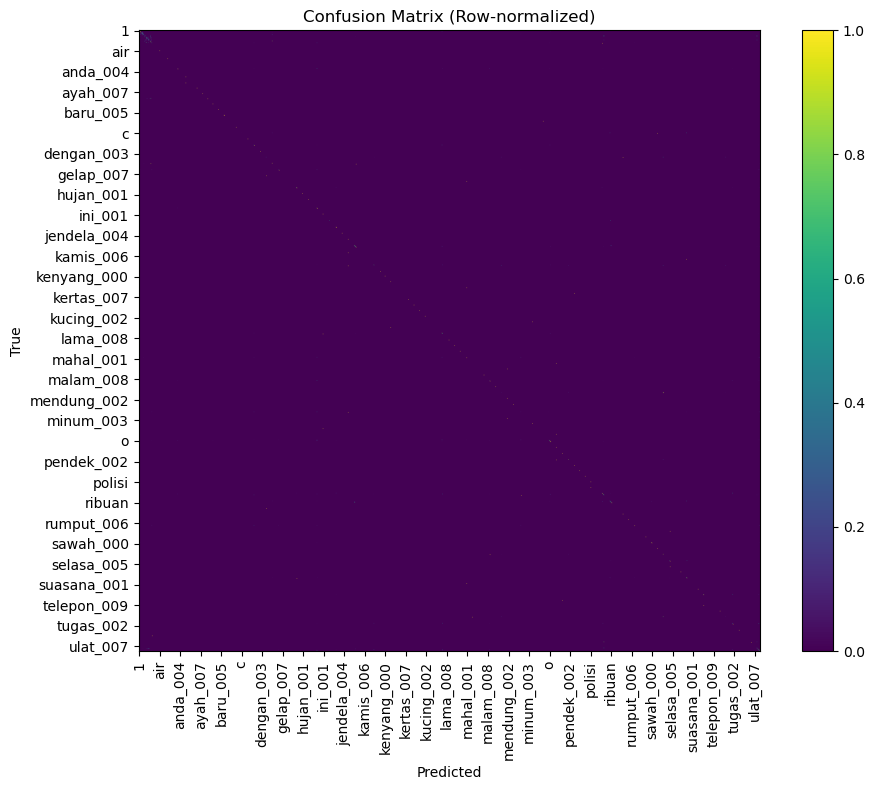

In [24]:
eval_loader = test_loader  # switch to val_loader if preferred

class_names = [id_to_label[i] for i in range(num_classes)]

y_true, y_pred, y_prob, topk_acc = evaluate_collect_predictions(
    model, eval_loader, device, k_list=(1, 3, 5)
)

cm = compute_confusion_matrix(y_true, y_pred, num_classes)
report, metrics = safe_classification_report(y_true, y_pred, target_names=class_names)

print("=== TOP-K ACCURACY ===")
for k, v in topk_acc.items():
    print(f"{k}: {v:.4f}")

print("\n=== SUMMARY METRICS ===")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

print("\n=== CLASSIFICATION REPORT ===")
print(report)

plot_confusion_matrix(cm, class_names, normalize=False, title="Confusion Matrix (Counts)")
plot_confusion_matrix(cm, class_names, normalize=True, title="Confusion Matrix (Row-normalized)")


In [25]:
import json

results_dir = Path("results_eval/")
results_dir.mkdir(parents=True, exist_ok=True)

np.save(results_dir / "confusion_matrix_counts.npy", cm)
np.save(results_dir / "y_true.npy", y_true)
np.save(results_dir / "y_pred.npy", y_pred)
np.save(results_dir / "y_prob.npy", y_prob)

summary = {
    "num_sequences_evaluated": int(len(y_true)),
    "num_classes": int(num_classes),
    "topk_acc": {k: float(v) for k, v in topk_acc.items()},
    "metrics": {k: float(v) for k, v in metrics.items()},
    "pad_len": int(pad_len),
    "features_per_frame": int(n_features),
    "seed": 42,
    "train_ratio": float(train_ratio),
    "val_ratio": float(val_ratio),
    "test_ratio": float(test_ratio),
}

with open(results_dir / "summary.json", "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2)

with open(results_dir / "classification_report.txt", "w", encoding="utf-8") as f:
    f.write(report)

print("[SAVED] Evaluation outputs in:", results_dir.resolve())


[SAVED] Evaluation outputs in: D:\Projects\Python\SIBIFullBody312\3_training\results_eval
